[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('./')

from helpers import utility_functions as ufn

In [3]:
def show_cross_val_scores(alg_name_scores, alg_name='Xgboost'):
    print(f"{alg_name} scores")
    print("%0.3f accuracy with a standard deviation of %0.3f" % (alg_name_scores['test_accuracy'].mean(), alg_name_scores['test_accuracy'].std()))
    print("%0.3f f1 score with a standard deviation of %0.3f" % (alg_name_scores['test_f1'].mean(), alg_name_scores['test_f1'].std()))
    print("%0.3f roc_auc with a standard deviation of %0.3f" % (alg_name_scores['test_roc_auc'].mean(), alg_name_scores['test_roc_auc'].std()))

In [4]:
def alg_score_plotting(alg1, alg2, alg3):
    """Plot cross validation scores for 3 algorithms
    """
    acc_data = {'Accuracy':  [xgb_scores['test_accuracy'].mean(), cbc_scores['test_accuracy'].mean(), lgbm_scores['test_accuracy'].mean()] }
    f1_data = {'F1 score':  [xgb_scores['test_f1'].mean(), cbc_scores['test_f1'].mean(), lgbm_scores['test_f1'].mean()] }
    roc_data = {'ROC-AUC score':  [xgb_scores['test_roc_auc'].mean(), cbc_scores['test_roc_auc'].mean(), lgbm_scores['test_roc_auc'].mean()] }
    alg_name_data = {'Algorithm name':  ['Xgboost classifier', 'Catboost classifier', 'LightGBM classifier']}
    

In [5]:
def get_feature_importance(alg_name_scores, dataset ,classifier_name='xgboost'):
    for idx,estimator in enumerate(alg_name_scores['estimator']):
#     print("Features sorted by their score for estimator {}:".format(idx))
        feature_importances_alg_name = pd.DataFrame(estimator.feature_importances_,
                                           index = dataset.columns,
                                            columns=['importance']).sort_values('importance', ascending=False)
    return feature_importances_alg_name

In [6]:
def feature_selector(alg_name, feature_importances, classifier_name, dataset, tags):
    selector = RFECV(alg_name, step=300, cv=10)
    selector = selector.fit(dataset, tags['result'])
    print(f"Optimum number of features for {classifier_name}: %d" % selector.n_features_)
    df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])

    for i in range(dataset.shape[1]):
        row = {'feature': i, 'support': selector.support_[i], 'ranking': selector.ranking_[i]}
        df_features = df_features.append(row, ignore_index=True)

    df_features.sort_values(by='ranking')
    selected_columns = dataset.columns[selector.get_support(1)]
    selected_feature_importances = feature_importances.loc[selected_columns,:]
    sorted_selected_feature_importances = selected_feature_importances.sort_values(by='importance',ascending=False)
    return sorted_selected_feature_importances

In [7]:
def alg_performance_table(alg1_scores, alg2_scores, alg3_scores, alg1_name, alg2_name, alg3_name):
    acc_data = {'Accuracy':  [alg1_scores['test_accuracy'].mean(), alg2_scores['test_accuracy'].mean(), alg3_scores['test_accuracy'].mean()] }
    f1_data = {'F1 score':  [alg1_scores['test_f1'].mean(), alg2_scores['test_f1'].mean(), alg3_scores['test_f1'].mean()] }
    roc_data = {'ROC-AUC score':  [alg1_scores['test_roc_auc'].mean(), alg2_scores['test_roc_auc'].mean(), alg3_scores['test_roc_auc'].mean()] }
    alg_name_data = {'Algorithm name':  [f'{alg1_name} classifier', f'{alg2_name} classifier', f'{alg3_name} classifier']} 
    df_acc_data = pd.DataFrame (acc_data, columns = ['Accuracy'])
    df_f1_data = pd.DataFrame (f1_data, columns = ['F1 score'])
    df_roc_data = pd.DataFrame (roc_data, columns = ['ROC-AUC score'])
    df_alg_name_data = pd.DataFrame (alg_name_data, columns = ['Algorithm name'])
    frames = [df_alg_name_data, df_acc_data, df_f1_data, df_roc_data]
    metrics_total = pd.concat(frames, axis=1)
    return metrics_total

In [8]:
def plot_alg_performance(total_metrics, color_code1, color_code2, color_code3):
    fig, ax = plt.subplots(figsize=(15,7.5))
    algorithms = total_metrics['Algorithm name']
    x = np.arange(len(algorithms))
    width = 0.15
    ax.bar(x - 3*width/2, total_metrics['Accuracy'], width, label='Accuracy', color=color_code1)
    ax.bar(x - width/2, total_metrics['F1 score'], width, label='F1 score', color=color_code2)
    ax.bar(x + width/2, total_metrics['ROC-AUC score'], width, label='ROC-AUC score', color=color_code3)
    ax.set_ylabel('measurements')
    ax.set_title('Algorithm metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms.astype(str).values, rotation='horizontal')
    ax.legend()
    plt.show()

In [9]:
def consensus_feature_creation(important_features_alg1, important_features_alg2, important_features_alg3):
    important_feature_list_alg1 = list(important_features_alg1.index)
    important_feature_list_alg2 = list(important_features_alg2.index)
    important_feature_list_alg3 = list(important_features_alg3.index)
    consensus_result = ufn.sorted_borda_rank([important_feature_list_alg1, important_feature_list_alg2, important_feature_list_alg3])
    ordered_consensus_genes = [i[0] for i in consensus_result]
    return ordered_consensus_genes

In [10]:
def controller(dataset, tags, outfile_name):
    # Initialize gradient boosting classifiers
    print('Initializing gradient boosting classifiers ...', end=' ')
    xgbclass = XGBClassifier(use_label_encoder=False, eval_metric='rmse', verbosity = 0, importance_type='gain', silent=True)
    cbc = CatBoostClassifier(iterations=100, verbose=0)
    lgbm = LGBMClassifier(importance_type='split')
    print('Done')
    
    # Perform 10 fold cross validation
    print('Performing 10 fold cross validation ...', end=' ')
    xgb_scores = cross_validate(xgbclass, dataset, Y['result'], scoring=('accuracy', 'f1', 'roc_auc'), cv=10, return_estimator =True)
    cbc_scores = cross_validate(cbc, dataset, Y['result'], scoring=('accuracy', 'f1', 'roc_auc'), cv=10, return_estimator =True)
    lgbm_scores = cross_validate(lgbm, dataset, Y['result'], scoring=('accuracy', 'f1', 'roc_auc'), cv=10, return_estimator =True)
    print('Done')
    
    # Show cross validation scores
    show_cross_val_scores(xgb_scores, alg_name='Xgboost')
    show_cross_val_scores(cbc_scores, alg_name='Catboost')
    show_cross_val_scores(lgbm_scores, alg_name='Lightgbm')
    
    # Show gradient boosting classifier performance
    total_metrics = alg_performance_table(xgb_scores, cbc_scores, lgbm_scores, 'Xgboost', 'Catboost', 'LightGBM')
    print(total_metrics)
    plot_alg_performance(total_metrics, '#0343df', '#e50000', '#ffff14')
    
    # Feature importance for each gradient boosting classifier
    print('Getting feature importance for XgBoost ...', end=' ')
    xgb_feature_importance = get_feature_importance(xgb_scores, dataset, classifier_name='Xgboost')
    print('Done')
    
    print('Getting feature importance for CatBoost ...', end=' ')
    cbc_feature_importance = get_feature_importance(cbc_scores, dataset, classifier_name='Catboost')
    print('Done')
    
    print('Getting feature importance for LightGBM ...', end=' ')
    lgbm_feature_importance = get_feature_importance(lgbm_scores, dataset, classifier_name='Lightgbm')
    print('Done')
    
    # Feature selection with RFECV
    print('Running RFECV for XgBoost ...', end=' ')
    important_features_xgboost = feature_selector(xgbclass, xgb_feature_importance, 'xgboost', dataset, Y)
    print('Done')
    
    print('Running RFECV for CatBoost ...', end=' ')
    important_features_catboost = feature_selector(cbc, cbc_feature_importance, 'catboost', dataset, Y)
    print('Done')
    
    print('Running RFECV for LightGBM ...', end=' ')
    important_features_lgbm = feature_selector(lgbm, lgbm_feature_importance, 'lightgbm', dataset, Y)
    print('Done')
    
    # Feature consensus with borda rank based count
    print('Running borda consensus ...', end=' ')
    consensus_features = consensus_feature_creation(important_features_xgboost, important_features_catboost, important_features_lgbm)
    # Create dataset only with the consensus' features
    consensus_dataset = dataset.loc[:, consensus_features]
    print('Done')
    
    print('Saving consensus dataset to .csv ...', end=' ')
    consensus_dataset.to_csv(f'{outfile_name}.csv', index=False)
    print('Done')

In [11]:
X = pd.read_csv('dataset_6000_cols.csv')

In [12]:
X

,1,4,7,9,10,13,14,15,17,18,...,18878,18879,18883,18892,18896,18917,18919,18921,18929,18943
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.358238
1,0.0,0.097849,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.029390,0.613685,0.000000,0.077729,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.033148,0.000000,0.064820,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.019525,0.000000,0.006286,0.058349,0.000000,0.040867,0.000000
3,0.0,0.077669,0.0,0.0,0.0,0.011943,0.000000,0.000000,0.000000,0.036564,...,0.000000,0.013722,0.010286,0.000000,0.010368,0.000000,0.021022,0.000000,0.044172,0.007648
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.492562,...,0.000000,0.000000,0.000000,0.000000,0.209504,0.000000,0.000000,0.000000,0.595041,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6173,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.145369,0.000000,...,0.052348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098137
6174,0.0,0.051106,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.027087,0.020305,0.027773,0.010233,0.039158,0.000000,0.025472,0.000000,0.000000
6175,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6176,0.0,0.025218,0.0,0.0,0.0,0.000000,0.196844,0.102366,0.000000,0.000000,...,0.011922,0.000000,0.000000,0.020557,0.015149,0.055479,0.000000,0.018854,0.043026,0.000000


In [13]:
Y = pd.read_csv('emtab_tags.csv')

In [14]:
Y

,result
0,0
1,0
2,0
3,0
4,0
...,...
6173,1
6174,1
6175,1
6176,1


Xgboost scores
0.887 accuracy with a standard deviation of 0.125
0.910 f1 score with a standard deviation of 0.125
0.967 roc_auc with a standard deviation of 0.051
Catboost scores
0.873 accuracy with a standard deviation of 0.136
0.898 f1 score with a standard deviation of 0.142
0.958 roc_auc with a standard deviation of 0.058
Lightgbm scores
0.892 accuracy with a standard deviation of 0.119
0.915 f1 score with a standard deviation of 0.118
0.969 roc_auc with a standard deviation of 0.049
        Algorithm name  Accuracy  F1 score  ROC-AUC score
0   Xgboost classifier  0.886713  0.909648       0.967103
1  Catboost classifier  0.873278  0.898083       0.958338
2  LightGBM classifier  0.892216  0.914643       0.968580


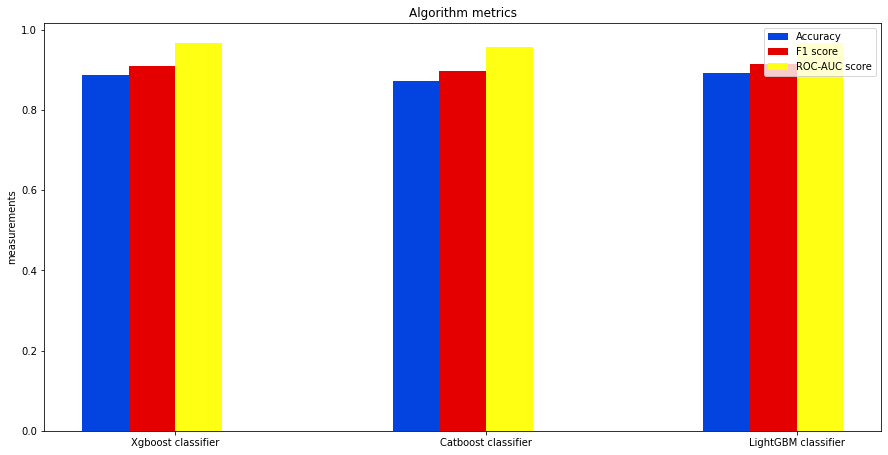

Optimum number of features for xgboost: 642
Optimum number of features for catboost: 42
Optimum number of features for lightgbm: 342
Xgboost scores
0.896 accuracy with a standard deviation of 0.123
0.916 f1 score with a standard deviation of 0.122
0.970 roc_auc with a standard deviation of 0.048
Catboost scores
0.884 accuracy with a standard deviation of 0.129
0.908 f1 score with a standard deviation of 0.128
0.965 roc_auc with a standard deviation of 0.051
Lightgbm scores
0.899 accuracy with a standard deviation of 0.118
0.920 f1 score with a standard deviation of 0.115
0.973 roc_auc with a standard deviation of 0.045
        Algorithm name  Accuracy  F1 score  ROC-AUC score
0   Xgboost classifier  0.895615  0.916443       0.970266
1  Catboost classifier  0.884283  0.908318       0.965463
2  LightGBM classifier  0.899174  0.919882       0.972798


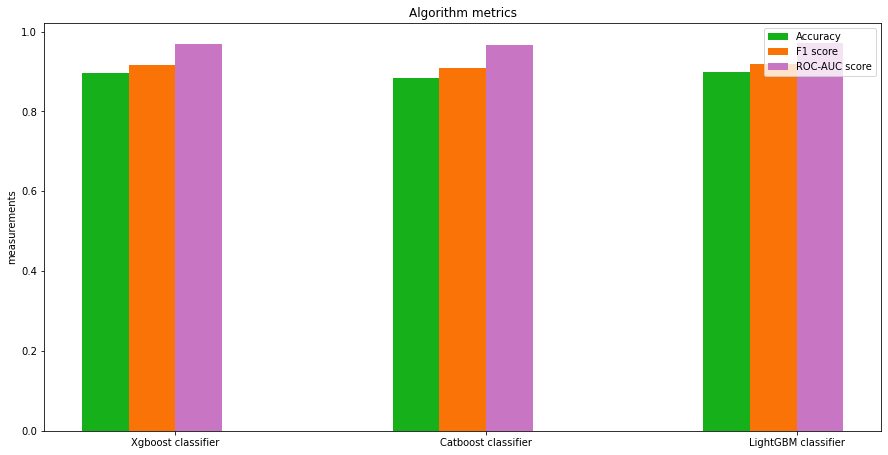

In [15]:
controller(X, Y['result'], 'consensus_data_6000.csv')